# Customer Segmentation

### Data analysis workflow

Selene Reyes

## Table of Content

1. [PROBLEM](#problem)<br>
2. [DATA](#data)<br>
3. [CUSTOMER SEGMENTATION](#rfm)<br>
    3.1 [CUSTOM RFM SEGMENTATION](#cus)<br>
    3.2 [SEGMENTS WITH UNSUPERVISED ML (K-MEANS)](#kmeans)

### Importing libraries

In [4]:
from urllib.request import urlretrieve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import datetime, date, timedelta
import os
from scipy.stats import ttest_ind
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

<a id='problem'></a>
# 1. Problem

In my [Jupyter Notebook](https://github.com/selenerc/Cohort-Analysis-and-CLTV/blob/master/Cohort-Analysis-CLV.ipynb) I performed cohort analysis using online retail data. The customer lifetime value was also determined, considering the customer loyalty. However, customers can be grouped into different groups according their behavior, and that will give the company a better understanding of how to allocate resources for customer acquisition and to define strategies.

In this notebook I built segments of homogeneous customers based on their behavior. I used two different approaches:
* Custom rules
* Unsupervised ML (k-means)

<a id='data'></a>
# 2. Data

This data set contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based online retail business. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

 __Data source:__ <br>
UCI Machine Learning Repository   __[Link to dataset](https://archive.ics.uci.edu/ml/datasets/Online%20Retail)__

In [1]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

In [5]:
def get_data(filename='online_retail.xlsx', url=URL):
    if not os.path.exists(filename):
        urlretrieve(url, filename)
    xls = pd.ExcelFile(filename)
    data = pd.read_excel(xls, parse_dates = ['InvoiceDate'])
    return data

In [6]:
online = get_data()

In [7]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [31]:
online.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70864 entries, 416792 to 312243
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    70864 non-null  int64         
 1   StockCode    70864 non-null  object        
 2   Description  70864 non-null  object        
 3   Quantity     70864 non-null  int64         
 4   InvoiceDate  70864 non-null  datetime64[ns]
 5   UnitPrice    70864 non-null  float64       
 6   CustomerID   70864 non-null  int64         
 7   Country      70864 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 4.9+ MB


<a id='rfm'></a>
# 3. Customer Segmentation 

### RFM stands for recency, frequency and monetary:

* Recency: time since the last customer transaction
* Frequency: number of purchases (transactions) in the observed period
* Monetary value: total amount spent in the observed period
* Tenure: time since the first transaction. It defines how long the customer has been with the company<br>

![RFM](RFM.png)

In [458]:
# Adding a column "Amount" which will be used to calculate the monetary value
online['Amount'] = online.UnitPrice * online.Quantity

In [459]:
online['InvoiceDate']= online.InvoiceDate.dt.round('D')
online = online.loc[(online.InvoiceDate >= '2010-12-10') & 
                    (online.InvoiceDate <= '2011-12-09')]

'Min:{}; Max:{}'.format(min(online.InvoiceDate), max(online.InvoiceDate))

'Min:2010-12-10 00:00:00; Max:2011-12-09 00:00:00'

In [460]:
# Hypothetical snapshot_day data
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)
snapshot_date.round('D')

Timestamp('2011-12-10 00:00:00')

In [461]:
# RFM metrics

# Calculate Recency, Frequency and Monetary value for each customer 
datamart = online.groupby(['CustomerID']).agg({
    # diff of the hypothetical today and the last transaction
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    # frequency of invoices
    'InvoiceNo': 'count',
    # Sum all the spend
    'Amount': 'sum'})

datamart.rename(columns={'InvoiceDate': 'Recency',
                        'InvoiceNo': 'Frequency',
                        'Amount': 'MonetaryValue'}, inplace=True)

datamart.head() # RFM for each customer as of today

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,25,948.7
12748,1,880,7032.0
12749,4,37,813.4
12820,3,17,268.0
12822,71,9,146.2


<a id='cus'></a>
## 3.1 Building custom RFM segments

### Categorization of RFM values using Percentiles-Based method: 
> ### Percentiles
>> 1. Sort customers based on metric
>> 2. Break customers into a pre-defined number of groups
>> 3. Assign label to each group

In [462]:
# low label is better - 4
r_labels = range(4,0,-1) 

r_quartiles = pd.qcut(datamart['Recency'], 4, labels= r_labels)

# assign values to a new column called "R"
datamart = datamart.assign(R = r_quartiles.values) 

# For frequency and monetary value, high label is better - 4 (visit more often, spend more)
f_labels = range(1,5)
m_labels = range(1,5)

f_quartiles = pd.qcut(datamart['Frequency'], 4, labels= f_labels)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels= m_labels)

datamart = datamart.assign(F = f_quartiles.values)
datamart = datamart.assign(M = m_quartiles.values)

datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12747,2,25,948.7,4,4,4
12748,1,880,7032.0,4,4,4
12749,4,37,813.4,4,4,4
12820,3,17,268.0,4,3,3
12822,71,9,146.2,2,2,3


In [463]:
# Build RFM Segment and FRM Score (sum of RFM value)

def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M']):
    """Creates the concatenated list of RFM values converted to strings
    
    Args:
        x (df): contains the columns R, F, and M
    
    Returns:
        (str): RFM values 
    """
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Score'] = datamart[['R', 'F', 'M']].sum(axis=1)

datamart.sort_values(by=['RFM_Segment']).head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
13682,187,2,42.5,1,1,1,111,3.0
15852,197,4,11.6,1,1,1,111,3.0
13551,319,1,17.9,1,1,1,111,3.0
17278,241,3,53.0,1,1,1,111,3.0
15882,199,1,5.9,1,1,1,111,3.0


### We can understand our segments or check specific customers

In [466]:
# Size of the 5 largest RFM segments
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:5]

RFM_Segment
444    368
111    343
211    169
344    164
233    131
dtype: int64

In [467]:
# Select 5 customers that are in the top RFM segment "444" 
datamart[datamart['RFM_Segment']=='444'][:5]

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,25,948.7,4,4,4,444,12.0
12748,1,880,7032.0,4,4,4,444,12.0
12749,4,37,813.4,4,4,4,444,12.0
12839,2,54,947.6,4,4,4,444,12.0
12841,5,70,631.0,4,4,4,444,12.0


## Summary metrics per RFM Score

>> ### Average and Frequency

In [468]:
datamart.groupby('RFM_Score').agg({'Recency': 'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         247.2       2.1          28.6   343
4.0         162.2       3.1          47.8   336
5.0         138.3       4.3          77.7   396
6.0         101.9       6.4         146.7   441
7.0          78.2       8.6         159.8   391
8.0          62.3      12.8         198.5   374
9.0          45.7      16.6         329.0   344
10.0         31.4      24.1         442.8   355
11.0         21.6      39.0         714.1   300
12.0          7.4      76.1        1665.6   368

## Grouping into custom segments
> ### Gold, Silver, Bronze

In [469]:
def segment_me(df):
    """Returns different segments: Gold, Silver, Bronze
    based on the RFM_Score value thresholds
    
    Args:
        df
    
    Returns:
        str: Gold, Silver, Bronze
    """
    if df['RFM_Score']>=9:
        return '1. Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return '2. Silver'
    else:
        return '3. Bronze'

In [471]:
# Create a variable called "Segment"
datamart['Segment'] = datamart.apply(segment_me, axis=1)

datamart.groupby('Segment').agg({'Recency': 'mean',
                                'Frequency': 'mean',
                                'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
Segment                                        
1. Gold      26.4      39.5         802.9  1367
2. Silver    95.8       7.9         144.9  1602
3. Bronze   205.2       2.6          38.1   679

### What is the average MonetaryValue for the segment with RFM_Score of 9?

In [474]:
monetary_value_9 = datamart[datamart.RFM_Score == 9].MonetaryValue.mean()
print(f'The average monetary value for a RFM score of 9 is $ {monetary_value_9:.0f}')

The average monetary value for a RFM score of 9 is $ 329


<a id='kmeans'></a>
## 3.2 Building segments with unsupervised ML (k-Means clustering)

To build this model itwas used k-Means, an unsupervised ML algorithm (it does not have labels to train the model).

### K-Means assumptions:
> ### - Symmetric distribution of variables 
> ### - Variables with same mean values 
> ### - Variables with same variance

## 3.2.1 Data Preprocessing

In [475]:
# RFM metrics

# Calculate Recency, Frequency and Monetary value for each customer 
data = online.groupby(['CustomerID']).agg({
    # diff of the hypothetical today and the last transaction
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days +1,
    # frequency of invoices
    'InvoiceNo': 'count',
    # Sum all the spend
    'Amount': 'sum'})

data.rename(columns={'InvoiceDate': 'Recency',
                        'InvoiceNo': 'Frequency',
                        'Amount': 'MonetaryValue'}, inplace=True)

data['Tenure'] = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.min()).days})

data.head() # RFM for each customer as of today

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12747,3,25,948.7,362
12748,2,880,7032.0,365
12749,5,37,813.4,213
12820,4,17,268.0,326
12822,72,9,146.2,87


In [476]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3648 entries, 12747 to 18287
Data columns (total 4 columns):
Recency          3648 non-null int64
Frequency        3648 non-null int64
MonetaryValue    3648 non-null float64
Tenure           3648 non-null int64
dtypes: float64(1), int64(3)
memory usage: 142.5 KB
None


### Checking symmetry (skewness)

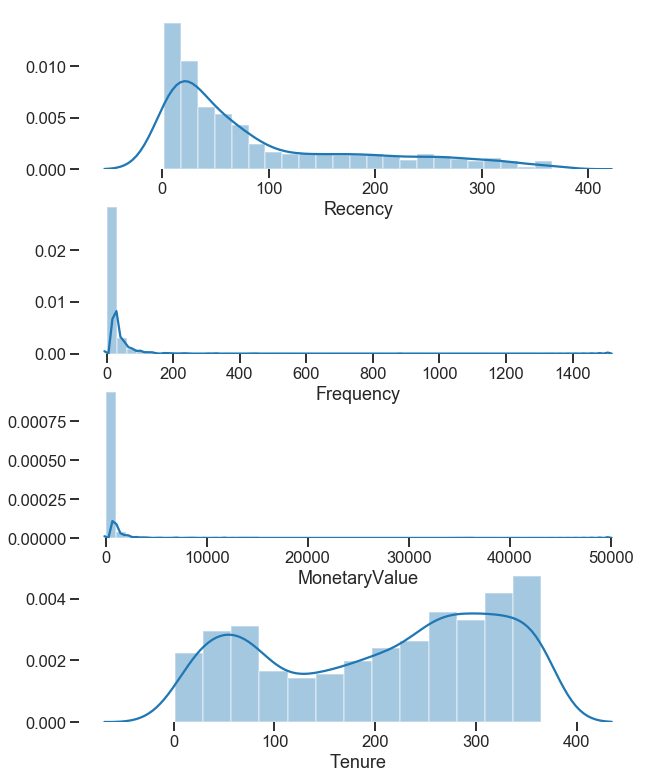

In [520]:
import warnings
warnings.filterwarnings('ignore')
import sys 
# Plot distribution of variables
plt.figure(figsize=(10, 13))
sns.set_context('talk', font_scale=1)
plt.subplot(4, 1, 1); sns.distplot(data['Recency'])
plt.box(False)
plt.subplot(4, 1, 2); sns.distplot(data['Frequency'])
plt.box(False)
plt.subplot(4, 1, 3); sns.distplot(data['MonetaryValue'])
plt.box(False)
plt.subplot(4, 1, 4); sns.distplot(data['Tenure'])
plt.box(False);

In [478]:
data.describe()

,Recency,Frequency,MonetaryValue,Tenure
count,3648.0,3648.0,3648.0,3648.0
mean,91.2,18.8,371.6,207.1
std,94.9,43.8,1365.4,113.4
min,2.0,1.0,0.7,1.0
25%,19.0,4.0,59.0,91.0
50%,52.0,9.0,136.9,233.0
75%,142.0,21.0,334.7,308.0
max,366.0,1510.0,49974.6,365.0


### The variables are skewed and are on different scales

### Sequence of the pre-processing pipeline
> ### 1. Unskew the data - log transformation
> ### 2. Standardize to the same average values
> ### 3. Scale to the same standaard deviation
> ### 4. Store as a separate array to be used for clustering

In [509]:
# Unskew the data with log transformation
data_log = np.log(data[['Recency', 'Frequency','MonetaryValue']])
data_log = data_log.assign(Tenure = data.Tenure) 

# Normalize the variables with StandardScaler (Scale and center the data)
# Substract avg value from each observation and dividing by the std ==> mean=0 and std=1
scaler = StandardScaler()
scaler.fit(data_log)

# Store as a separate array to be used for clustering
data_normalized = scaler.transform(data_log)

# Create a pandas DataFrame
data_normalized = pd.DataFrame(data=data_normalized, 
                                   index=data_log.index, 
                                   columns=data_log.columns)

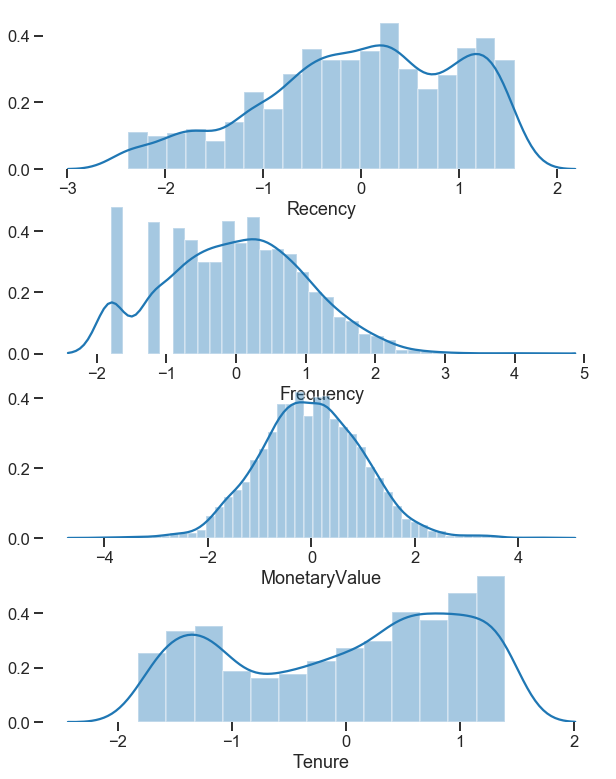

In [519]:
# Plot distribution of variables
plt.figure(figsize=(10, 13))
plt.subplot(4, 1, 1); sns.distplot(data_normalized['Recency'])
plt.box(False)

plt.subplot(4, 1, 2); sns.distplot(data_normalized['Frequency'])
plt.box(False)

plt.subplot(4, 1, 3); sns.distplot(data_normalized['MonetaryValue'])
plt.box(False)

plt.subplot(4, 1, 4); sns.distplot(data_normalized['Tenure'])
plt.box(False);

In [481]:
data_normalized.describe().round(1)

,Recency,Frequency,MonetaryValue,Tenure
count,3648.0,3648.0,3648.0,3648.0
mean,0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0
min,-2.4,-1.8,-4.1,-1.8
25%,-0.7,-0.7,-0.7,-1.0
50%,0.1,0.0,-0.0,0.2
75%,0.9,0.7,0.7,0.9
max,1.6,4.3,4.5,1.4


## 3.2.2 Implementation of k-means clustering 
### Steps:
> ### 1. Choosing a number of clusters
> ### 2. Running k-means clustering on pre-processed data
> ### 3. Analyzing RFM values of each cluster

### 1. Choosing number of clusters

### Elbow method ==> choose a _k_ so that the SSE of the distances decreases drastically

In [486]:
# SSE: sum of squared errors
# Fit KMeans and calculate SEE for each *k*

see = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    see[k] = kmeans.inertia_ #sum of squared distances to closest cluster center

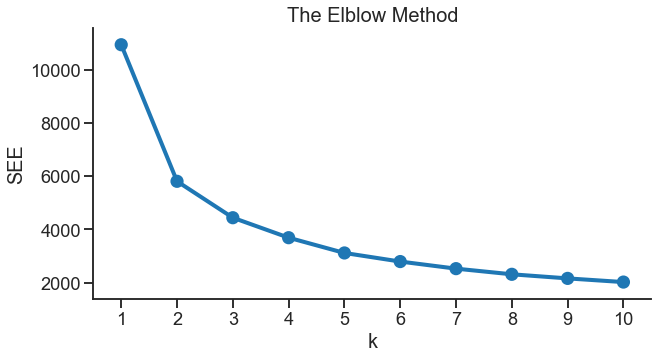

In [523]:
# Plot SEE for each *k*
plt.figure(figsize=(10, 5))
sns.set_context('talk', font_scale=1.1)
sns.set_style("ticks")
plt.title('The Elblow Method', size=20)
plt.xlabel('k')
plt.ylabel('SEE')
sns.pointplot(x=list(see.keys()), y=list(see.values()))
sns.despine();

### 2. Running k-means clustering on pre-processed data

In [488]:
kmeans = KMeans(n_clusters = 4, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_

In [514]:
# Create a cluster label column in the original DataFrame + cluster column
datamart_rfmt_k4 = data.assign(Cluster = cluster_labels)

# Group by cluster
grouped = datamart_rfmt_k4.groupby(['Cluster'])

# Calculate average, median RFMT values and segment sizes for each cluster
grouped.agg({
    'Recency': ['mean','median'],
    'Frequency': ['mean','median'],
    'MonetaryValue': ['mean','median'],
    'Tenure': ['mean','median','count']
  }).round(1).T

Cluster                    0       1      2       3
Recency       mean      13.8    41.3  221.1    98.6
              median    10.0    34.0  220.0    69.5
Frequency     mean      55.4     7.7    3.3    16.0
              median    37.0     5.0    3.0    13.0
MonetaryValue mean    1176.0   118.6   57.7   300.4
              median   609.1    78.2   45.3   212.3
Tenure        mean     288.3    65.2  238.2   274.5
              median   313.0    59.0  243.0   281.0
              count    744.0  1085.0  801.0  1018.0

### 3. Analyzing RFM values of each cluster

In [502]:
def plotting_boxplot(df):
    """Generates boxplots of the RFMT variables by cluster, 
    using the results of the cluster"""
    for column in df:
        if column not in ['Cluster', 'MonetaryValue','Frequency']:
            box_plot_df = pd.melt(df[[str(column), 'Cluster']],
                  id_vars="Cluster",
                  var_name="feature",
                  value_name='value')
        
            plt.figure(figsize=(12, 4))
            sns.boxplot(x="feature",y="value", hue="Cluster", 
                        data=box_plot_df, palette='Blues', width=.5)
            plt.title('Distribution of ' + str(column)+' (in days)\n', size = 16)
            plt.ylim(0,400)
            plt.legend(loc='best', title= 'Clusters');
        
        elif column in ['MonetaryValue']:
            box_plot_df = pd.melt(df[[str(column), 'Cluster']],
                  id_vars="Cluster",
                  var_name="feature",
                  value_name='value')
        
            plt.figure(figsize=(12, 4))
            sns.boxplot(x="feature",y="value", hue="Cluster", 
                        data=box_plot_df, palette='Blues', width=.5)
            plt.title('Distribution of ' + str(column)+' ($)\n', size = 16)
            plt.ylim(0,1200)
            plt.legend(loc='best', title= 'Clusters');
        
        elif column in ['Frequency']:
            box_plot_df = pd.melt(df[[str(column), 'Cluster']],
                  id_vars="Cluster",
                  var_name="feature",
                  value_name='value')
        
            plt.figure(figsize=(12, 4))
            sns.boxplot(x="feature",y="value", hue="Cluster", 
                        data=box_plot_df, palette='Blues', width=.5)
            plt.title('Distribution of ' + str(column)+' (Number)\n', size = 16)
            plt.ylim(0,80)
            plt.legend(loc='best', title= 'Clusters');       
        
        else:
            print('')

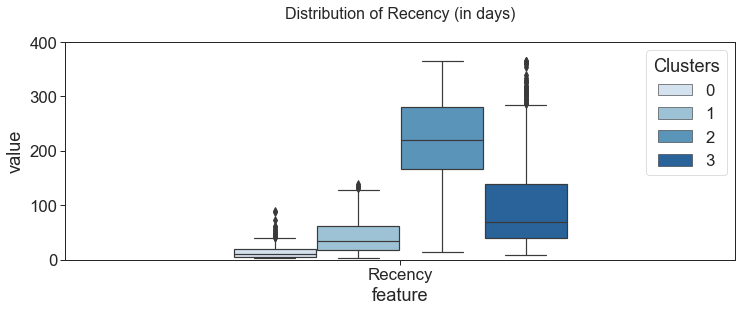

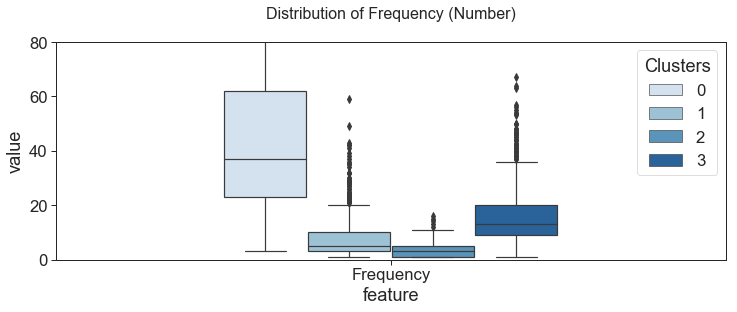

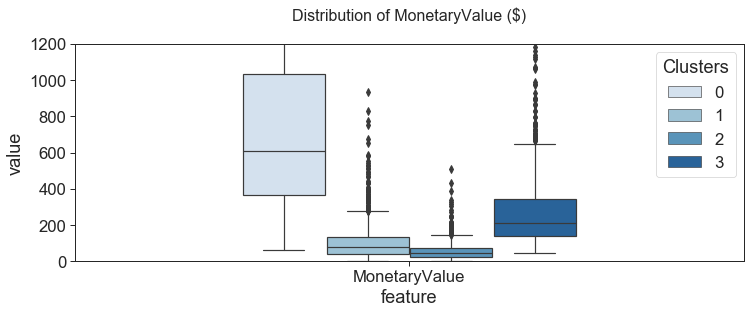

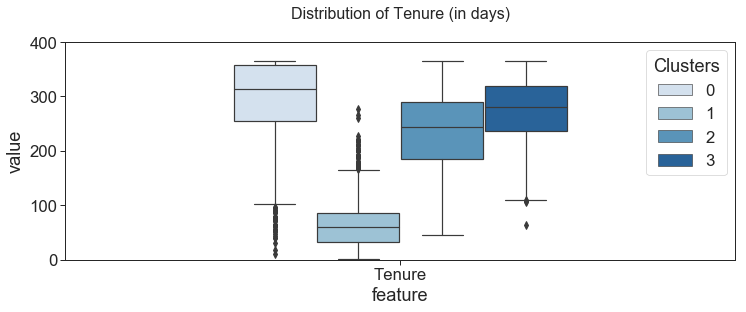

In [503]:
plotting_boxplot(datamart_rfmt_k4)

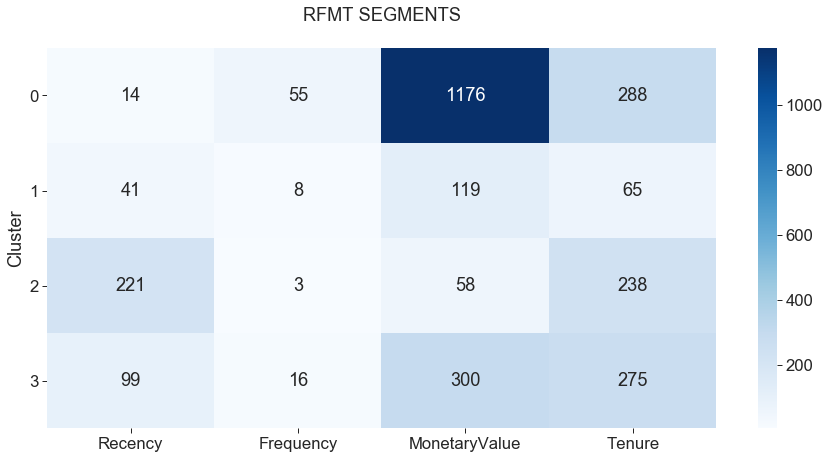

In [500]:
grouped_averages = datamart_rfmt_k4.groupby(['Cluster']).mean().round(0)

plt.figure(figsize=(15,7))
sns.set_context('paper', font_scale=1.9)
plt.title('RFMT SEGMENTS\n')
g = sns.heatmap(data=grouped_averages, annot=True, fmt='.0f',cmap='Blues')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right');